# NYC Metro Challenge

## Field Description

- C/A = Control Area (A002)
- UNIT = Remote Unit for a station (R051)
- SCP = Subunit Channel Position represents an specific address for a device (02-00-00)
- DATEn = Represents the date (MM-DD-YY)
- TIMEn = Represents the time (hh:mm:ss) for a scheduled audit event
- DEScn = Represent the "REGULAR" scheduled audit event (occurs every 4 hours)
- ENTRIESn = The cumulative entry register value for a device
- EXISTn = The cumulative exit register value for a device

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib.ticker import EngFormatter
import seaborn as sns

from darts import TimeSeries
from darts.models import RegressionModel, LinearRegressionModel
from darts.metrics import mape

import tqdm
from operator import itemgetter
import glob
import shutil
import py7zr

## Understanding the Dataset

Let's begin importing just one dataset and work to understand the data

In [2]:
file_name = glob.glob('data/*.7z')
temp_folder = 'data/temp'

with py7zr.SevenZipFile(file_name[0], 'r') as archive:
    file_names = archive.getnames()
    archive.extractall(path=temp_folder)

    path_data_sets = glob.glob(temp_folder + '/*/*')
    df = pd.read_csv(path_data_sets[0])

try:
    shutil.rmtree(temp_folder)
except OSError as e:
   print("Error: %s - %s." % (e.filename, e.strerror))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7420384 entries, 0 to 7420383
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   time      object 
 1   ca        object 
 2   unit      object 
 3   scp       object 
 4   station   object 
 5   linename  object 
 6   division  object 
 7   desc      object 
 8   entries   float64
 9   exits     float64
dtypes: float64(2), object(8)
memory usage: 566.1+ MB


In [4]:
df.head(1)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704717.0,928793.0


The columns are different from the field description. Since the original page of the data is not available, I'll have to guess here and a **research on the internet for a compleat documentation**.

**Field Description**

- TIME [TIME]:
    - Represents the time of the reported data (HH:MM:SS);
    - The normal interval between audit reports for the same device is 4 hours. The four hour intervals will differ from other stations due to the need for staggering to prevent flooding the system with audit readings all at once. Systemwide, stations have been set to begin audit transmittal between 00 to 03 hours, then every 4 hours after the first audit of the day;
    - Example: **02:00:00**.
- C/A [TEXT]:
    - Control Area name/Booth name. This is the internal identification of a booth at a given station;
    - Examples - **A002** (4 to 5 characters).
- UNIT [TEXT]:
    - Remote unit ID of station;
    - Examples - **R001** (4 characters. A numeric designation preceded by 'R').
- SCP [TEXT]:
    - Subunit/Channel/position represents a specific address for a given device;
    - Example: **01-00-01** - Normally six characters in groups of 2 separated by a dash.
- STATION [TEXT]:
    - Name assigned to the subway station by operations planning. This name is used in all references to stations, as well as in debit/credit purchase receipts, and customer’s bank activity statements;
    - Example: **34 ST-HERALD SQ** - Maximum station name length is 15 characters.
- LINENAME [TEXT]:
    - Train lines stopping at this location. Can contain up to 20 single character identifier. When more than one train line appears, it is usually intercepting train lines, in major stations where the passenger can transfer between any one of the lines;
    - Example: **456** - Maximum station name length is 15 characters.
- DIVISION [TEXT]:
    - Represents the Line originally the station belonged to BMT, IRT, or IND;
    - Each section of the system is assigned a unique line name, usually paired with its original operating company or division (Brooklyn–Manhattan Transit Corporation (BMT), Interborough Rapid Transit Company (IRT), and Independent Subway System (IND);
    - From a reseach on the internet I've found
        - 'IRT': 'Interborough Rapid Transit',
        - 'BMT': 'Brooklyn-Manhattan Transit',  
        - 'IND': 'Independent Subway',
        - 'PTH': 'Port Authority Trans-Hudson (PATH)',
        - 'RIT': 'Roosevelt Island Tram',
        - 'SRT': 'Staten Island Rapid Transit' 
    - Example: **BMT** - 3 character in length.
- DESC [TEXT]:
    - Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours):
        1. Audits may occur more frequently than 4 hours due to planning, or troubleshooting activities;
        2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. If a recovered audit is sent and is identical to the previous register reading, it will be omitted.
    - Example: **REGULAR**.
- ENTRIES [NUMERIC]:
    - The cumulative ENTRY register value for a device. This register was initialized during system setup. It is a 10 digit number representing the number of entries on the specific device since its inception. Other forms of initialization may occur upon roll-over of the counter, erasing the memory device containing the register data, and replacing the processing device of the turnstile;
    - Example: **0001649720**.
- EXITS [NUMERIC]:
    - The cumulative EXITS register value for a device. This register was initialized during system setup. It is a 10 digit number representing the number of entries on the specific device since its inception. Other forms of initialization may occur upon roll-over of the counter, erasing the memory device containing the register data, and replacing the processing device of the turnstile;
    - Example: **0004863606**.

Along with this field description I've found more documentation with important infos.

**Data Collection Methodology**

The audit register data is extracted from a central database weekly on Saturdays for posting. The actual register data is generated at the turnstile device every 4 hours at which time the device uploads the data to a central database.

**Statistical and Analytic Issues**

The data is broken down to Daily and Hourly periods. The data is 10 digits long and will roll-over to zero (0) on over-flow. Other factors that may impact the data are:
- Hardware failure where the hard drive needs to be replaced, and initialized;
- Data corruption from faulty devices, or heavy banging on the turnstile.

From that information I made some decisions about the use of this dataframe:
1. Use only the regular data defined by the field `desc == 'REGULAR'`;
2. The `time` column must be transformed to the `pd.DateTime` type;
3. The accumulated counter can be reset due to unforeseen circumstances, so when calculating the instantaneous value, this care must be taken;
4. The datasets are huge, so the object columns with string values should be transformed to category type if the uniques values from each column are few in comparison to the total number of entries;
5. Sort the characters of `linename` column entries.

First transform the time columns from object to timestamp.

In [5]:
df['time'] = pd.to_datetime(df['time'])

Taking only the `desc == 'REGULAR'` entries.

In [6]:
df = df[df['desc'] == 'REGULAR']
df = df.drop(['desc'], axis = 1)

Count how many unique values are on each object column.

In [7]:
for column in df.columns:
        if df[column].dtypes == np.object0:
            print(f'{column.ljust(12)} {df[column].nunique()}')


ca           727
unit         467
scp          205
station      382
linename     107
division     6


The number of unique values is very small compared to the entire data frame. Let's convert these columns to categorical type.

In [8]:
object_columns = [_ for _ in df.columns if df[_].dtype == np.object0]
for column in object_columns:
        df[column] = pd.Categorical(df[column])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6099893 entries, 0 to 7420383
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   time      datetime64[ns]
 1   ca        category      
 2   unit      category      
 3   scp       category      
 4   station   category      
 5   linename  category      
 6   division  category      
 7   entries   float64       
 8   exits     float64       
dtypes: category(6), datetime64[ns](1), float64(2)
memory usage: 244.4 MB


The entries and exits are a discrete count so let's convert to integer type.

In [10]:
#df['entries'] = df['entries'].astype(int)
#df['exits'] = df['exits'].astype(int)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6099893 entries, 0 to 7420383
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   time      datetime64[ns]
 1   ca        category      
 2   unit      category      
 3   scp       category      
 4   station   category      
 5   linename  category      
 6   division  category      
 7   entries   float64       
 8   exits     float64       
dtypes: category(6), datetime64[ns](1), float64(2)
memory usage: 244.4 MB


The memory occupied by this dataframe is reasonably small, so let's work with it in its entirety without having to sample it.

In [12]:
df.head()

,time,ca,unit,scp,station,linename,division,entries,exits
0,2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,2704717.0,928793.0
1,2010-04-17 04:00:00,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,2697632.0,566683.0
2,2010-04-17 04:00:00,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,1127722.0,3943492.0
3,2010-04-17 04:00:00,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,2425570.0,3733289.0
4,2010-04-17 04:00:00,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,2214633.0,3021589.0


Let's take a closer look to the `linename` column where the description says:
- LINENAME [TEXT]:
    - Train lines stopping at this location. Can contain up to 20 single character identifier. When more than one train line appears, it is usually intercepting train lines, in major stations where the passenger can transfer between any one of the lines;
    - Example: **456** - Maximum station name length is 15 characters.

In [13]:
df['linename'].unique()

['456NQR', 'NQR', '1237ACENQRS', 'BDFMNQR', 'NR', ..., 'BDFQ6', '2345ACJZ', '2', 'EM', '123ACE']
Length: 108
Categories (107, object): ['1', '123', '1237ACENQRS', '123ACE', ..., 'R1', 'R2345', 'S', 'S2345']

We have two different values for apparently the same `linename` due to character sorting problems.:
- LNQR456;
- LNRQ456.

So we need to sort this characters in all strings of this column.

In [14]:
def sort_linename(linename):
    """
    Receive a string and sort its characters.

    Args:
        linename (string): Lines that cross a given station.

    Returns:
        string: Sorted train lines.
    """
    linename = str(linename)
    return ''.join(sorted(linename))

In [15]:
df.linename = pd.Categorical(df.linename.apply(sort_linename))

In [16]:
df['linename'].nunique()

92

The older number of unique values in this columns was 107 and now is 93. Now let's sort the columns.

In [17]:
df = df[['time', 'division', 'station', 'unit', 'linename','ca', 'scp', 'entries', 'exits']]
df.head()

,time,division,station,unit,linename,ca,scp,entries,exits
0,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704717.0,928793.0
1,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-01,2697632.0,566683.0
2,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-00,1127722.0,3943492.0
3,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-01,2425570.0,3733289.0
4,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-02,2214633.0,3021589.0


Now we check if this cumulative entries and exits count grow in a regular speed.
1. We first choose a value for each column to find the counts for a single turnstile.

In [18]:
sample_division = 'BMT'
sample_station = 'LEXINGTON AVE'
sample_unit = 'R051'
sample_linename = '456NQR'
sample_ca = 'A002'
sample_scp = '02-00-00'

mask_turnstile = (df.division == sample_division) \
    & (df.station == sample_station) \
    & (df.unit == sample_unit) \
    & (df.linename == sample_linename) \
    & (df.ca == sample_ca) \
    & (df.scp == sample_scp)

2. Use this mask to filter just one turnstile.

In [19]:
df_sample = df[mask_turnstile]
df_sample.head()

,time,division,station,unit,linename,ca,scp,entries,exits
0,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704717.0,928793.0
4795,2010-04-17 08:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704723.0,928795.0
10865,2010-04-17 12:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704731.0,928816.0
15916,2010-04-17 16:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704835.0,928898.0
20902,2010-04-17 20:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2705074.0,928943.0


3. Plot the cumulative count for the entries and exits values from this turnstile to inquire the count.

C:\Users\alvar\AppData\Local\Temp\ipykernel_136732\123266128.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


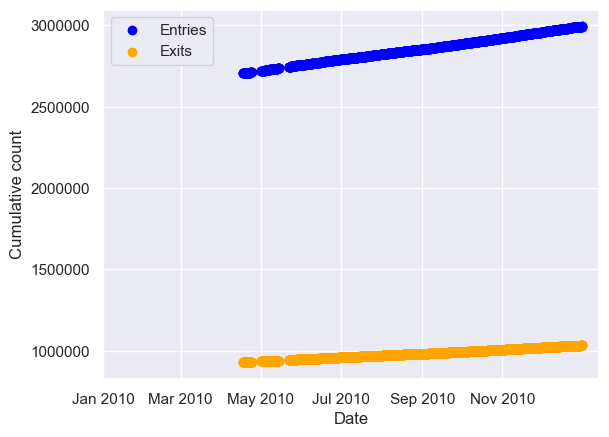

In [20]:
months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
plt.rc('date.autoformatter', day='%b %Y')

plt.scatter(x=df_sample.time, y=df_sample.entries, color='blue', label='Entries')
plt.scatter(x=df_sample.time, y=df_sample.exits, color='orange', label='Exits')
plt.ylabel('Cumulative count')
plt.xlabel('Date')
plt.xticks(months_interval)
plt.legend()
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
plt.show()

Cumulative entries and exits counts grow at constant rates. Now we need a method that samples this dataframe at different frequencies.

4. Sample this DataFrame in a temporal serie with a monthly frequency.

In [21]:
group_sample = df_sample.groupby([pd.Grouper(key='time', freq='M', closed='right')]).agg(
    entries=('entries', 'unique'),
    exits=('exits', 'unique')
).reset_index()

In [22]:
group_sample.head()

,time,entries,exits
0,2010-04-30,"[2704717.0, 2704723.0, 2704731.0, 2704835.0, 2...","[928793.0, 928795.0, 928816.0, 928898.0, 92894..."
1,2010-05-31,"[2721143.0, 2721154.0, 2721172.0, 2721259.0, 2...","[934743.0, 934746.0, 934771.0, 934853.0, 93492..."
2,2010-06-30,"[2756507.0, 2756565.0, 2756566.0, 2756612.0, 2...","[947574.0, 947593.0, 947596.0, 947692.0, 94799..."
3,2010-07-31,"[2791678.0, 2791833.0, 2791835.0, 2791859.0, 2...","[960153.0, 960171.0, 960176.0, 960237.0, 96046..."
4,2010-08-31,"[2822921.0, 2823005.0, 2823024.0, 2823028.0, 2...","[971379.0, 971391.0, 971397.0, 971406.0, 97143..."


On each entry on `entries` and `exits` column we have an array whit the cumulative count on that monthly frequency, so:

 5. Write the a method that takes a series with cumulated count and return the instant value.

In [23]:
def series_deacumulate(serie):
    """
        This method takes a series with cumulated count and return the instant value of each entry by de-acumulate the count.
        It also drops any negative value generated by the reset of the accumulated counter.

    Args:
        serie (np.array): Cumulative count sequence.
    """
    
    diff_serie = serie[1:] - serie[:-1]
    new_serie = diff_serie[diff_serie >= 0]
    return new_serie

In [24]:
group_sample['entries'] = group_sample['entries'].apply(series_deacumulate).apply(sum)
group_sample['exits'] = group_sample['exits'].apply(series_deacumulate).apply(sum)

In [25]:
group_sample.head()

,time,entries,exits
0,2010-04-30,8382.0,2980.0
1,2010-05-31,35162.0,12788.0
2,2010-06-30,34404.0,12509.0
3,2010-07-31,31025.0,11203.0
4,2010-08-31,29536.0,10756.0


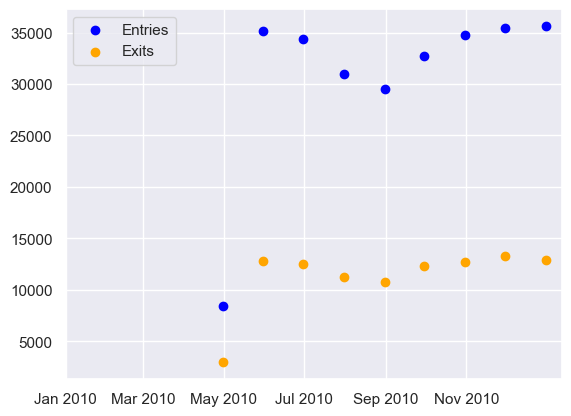

In [26]:
months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
plt.rc('date.autoformatter', day='%b %Y')

plt.scatter(x=group_sample.time, y=group_sample.entries, color='blue', label='Entries')
plt.scatter(x=group_sample.time, y=group_sample.exits, color='orange', label='Exits')
plt.legend()
plt.xticks(months_interval)
plt.show()

The graph with the number of passengers per month of a single turnstile shows a typical behavior of a time series, with moments of high and low movement.

When calculating instantaneous values for all stations, the time series for number of entries and exits must be reasonably close.

In [27]:
group = df.groupby([pd.Grouper(key='time', freq='M', closed='right')]).agg(
    entries=('entries', 'unique'),
    exits=('exits', 'unique')
).reset_index()

In [28]:
group['entries'] = group['entries']
group['exits'] = group['exits']
group['entries_inst'] = group['entries'].apply(series_deacumulate).apply(sum)
group['exits_inst'] = group['exits'].apply(series_deacumulate).apply(sum)

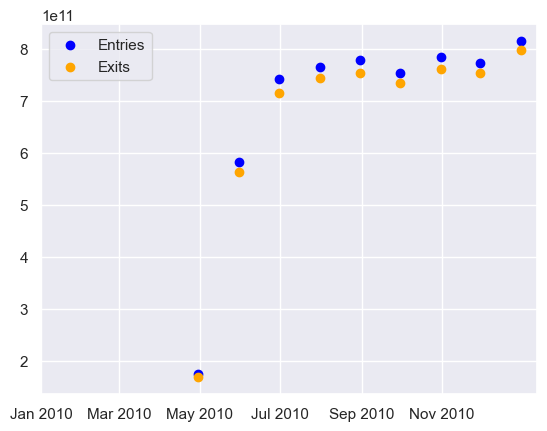

In [29]:
months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
plt.rc('date.autoformatter', day='%b %Y')

plt.scatter(x=group.time, y=group.entries_inst, color='blue', label='Entries')
plt.scatter(x=group.time, y=group.exits_inst, color='orange', label='Exits')
plt.legend()
plt.xticks(months_interval)
plt.show()

These methods filters, samples the data according to a temporal frequency, groups and calculates the instantaneous value of entries and exits.

### Data Processing Methods

Here we will group the methods used to process the data for this analysis.

In [14]:
def sort_linename(linename):
    """
    Receive a string and sort its characters.

    Args:
        linename (string): Lines that cross a given station.

    Returns:
        string: Sorted train lines.
    """
    linename = str(linename)
    return ''.join(sorted(linename))

In [3]:

def read_mta_data(df):
    """
    Read a csv file from the NYC MTA:
    
        1. Filters the entries with desc == 'REGULAR';
        2. Converts the time columns to timestamp format;
        3. Sort the lines in the linename column;
        4. Converts the object columns to category type.

    Args:
        file_path (string): Path to the .csv file.

    Returns:
        pd.DataFrame: preprocessed MTA DataFrame.
    """
    
    df = df[df.desc == 'REGULAR']
    df = df.drop(['desc'], axis = 1)
    
    df.time = pd.to_datetime(df.time)
    df.linename= df.linename.apply(sort_linename)
    
    object_columns = [_ for _ in df.columns if df[_].dtype == np.object0]
    for column in object_columns:
        df[column] = pd.Categorical(df[column])
    
    df = df[['time', 'division', 'station', 'unit', 'linename','ca', 'scp', 'entries', 'exits']]
    
    return df

In [17]:
def series_deacumulate(serie):
    """
        This method takes a series with cumulated count and return the instant value of each entry by de-acumulate the count.
        It also drops any negative value generated by the reset of the accumulated counter.

    Args:
        serie (np.array): Cumulative count sequence.
    """
          
    diff_serie = serie[1:] - serie[:-1]
    new_serie = diff_serie[diff_serie >= 0]
    return new_serie

In [5]:
def generate_time_series(df, freq):
    
    """
    
    Receives a DataFrame with the data sampling frequency and the turnstile filtering parameters.
    
    The cumulative entries and exits are grouped along a timestamp with the defined frequency.
    
    A new DataFrame is build with the parameters columns and the instant value for entries and exits.

    Returns:
        pd.DataFrame: Instant entries and exits DataFrame with new frequency time column.
    """
    
    group = df.groupby(
        [
            pd.Grouper(key='time', freq=freq, closed='right')
        ]
    ).agg(
        entries=('entries', 'unique'),
        exits=('exits', 'unique')
    ).reset_index()
    
    df_time_series = pd.DataFrame({}, columns=['time'])
    
    df_time_series.time = group.time
    df_time_series['divison'] = division
    df_time_series['station'] = station
    df_time_series['unit'] = unit
    df_time_series['linename'] = linename
    df_time_series['ca'] = ca
    df_time_series['scp'] = scp
    df_time_series['entries'] = group.entries
    df_time_series['exits'] = group.exits
    df_time_series['entries_inst'] = group['entries'].apply(series_deacumulate).apply(sum).astype(float)
    df_time_series['exits_inst'] = group['exits'].apply(series_deacumulate).apply(sum).astype(float)
    
    return df_time_series

## Importing Datasets

Unpacking the 7zip file and importing the data.

In [6]:
file_name = 'data/Dataset-Prova.7z'
temp_folder = 'data/temp'

with py7zr.SevenZipFile(file_name, 'r') as archive:
    archive.extractall(path=temp_folder)
    
    path_data_sets = glob.glob(temp_folder + '/*/*')
    df_concat = read_mta_data(pd.concat([pd.read_csv(_) for _ in path_data_sets], ignore_index=True))
    
try:
    shutil.rmtree(temp_folder)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

In [7]:
df_concat.head()

,time,division,station,unit,linename,ca,scp,entries,exits
0,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704717.0,928793.0
1,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-01,2697632.0,566683.0
2,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-00,1127722.0,3943492.0
3,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-01,2425570.0,3733289.0
4,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-02,2214633.0,3021589.0


In [8]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72112005 entries, 0 to 79609190
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   time      datetime64[ns]
 1   division  category      
 2   station   category      
 3   unit      category      
 4   linename  category      
 5   ca        category      
 6   scp       category      
 7   entries   float64       
 8   exits     float64       
dtypes: category(6), datetime64[ns](1), float64(2)
memory usage: 2.8 GB


Exporting data to file in order to save time.

In [9]:
df_concat.to_parquet('data/df_preprocessed.gzip', compression='gzip')

In [10]:
del(df_concat)

## Exploratory data analysis

Since the preprocessed dataframe was exported, we can continue the analysis from this check point.

In [3]:
df = pd.read_parquet('data/df_preprocessed.gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72112005 entries, 0 to 79609190
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   time      datetime64[ns]
 1   division  category      
 2   station   category      
 3   unit      category      
 4   linename  category      
 5   ca        category      
 6   scp       category      
 7   entries   float64       
 8   exits     float64       
dtypes: category(6), datetime64[ns](1), float64(2)
memory usage: 2.8 GB


In [265]:
df.head()

,time,division,station,unit,linename,ca,scp,entries,exits
0,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704717.0,928793.0
1,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-01,2697632.0,566683.0
2,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-00,1127722.0,3943492.0
3,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-01,2425570.0,3733289.0
4,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-02,2214633.0,3021589.0


### Dataframe Profiling

In [107]:
%%capture
profile = ProfileReport(df.sample(50_000))
profile.to_file('df_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Quick Analysis

Let's continue the analysis by taking a closer look on the timeseries for one single turnstile. In order to plot this series we need to write the method that will filter, group and deacumulate the count.

In [192]:
def generate_group_time_by_device(df, freq, division, station, unit, linename, ca, scp):
    
    """
    
    Receives a DataFrame with the data sampling frequency and the turnstile filtering parameters.
    
    The cumulative entries and exits are grouped along a timestamp with the defined frequency.
    
    A new DataFrame is build with the parameters columns and the instant value for entries and exits.

    Returns:
        pd.DataFrame: Instant entries and exits DataFrame with new frequency time column.
    """
    
    df = df[
        (df.division == division) \
        & (df.station == station) \
        & (df.unit == unit) \
        & (df.linename == linename) \
        & (df.ca == ca) \
        & (df.scp == scp) \
    ]
    
    group = df.groupby(
        [
            pd.Grouper(key='time', freq=freq, closed='right', label ='right')
        ]
    ).agg(
        entries=('entries', 'unique'),
        exits=('exits', 'unique')
    ).reset_index()
    
    df_time_series = pd.DataFrame({}, columns=['time'])
    
    df_time_series.time = group.time
    df_time_series['entries_inst'] = group['entries'].apply(series_deacumulate).apply(np.sum)
    df_time_series['exits_inst'] = group['exits'].apply(series_deacumulate).apply(np.sum)
    
    return df_time_series

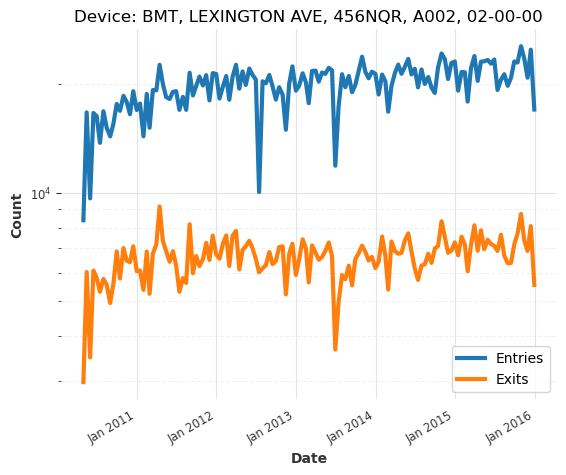

In [193]:
group_time = generate_group_time_by_device(df, 'SM', 'BMT', 'LEXINGTON AVE', 'R051', '456NQR', 'A002', '02-00-00')

fig, ax = plt.subplots()
ax.plot(group_time.time, group_time.entries_inst, lw=3, color='tab:blue', label='Entries')
ax.plot(group_time.time, group_time.exits_inst, lw=3, color='tab:orange', label='Exits')

# Set up grid, legend, and limits
ax.grid('both')
ax.grid(which='major', alpha=0.8, linestyle= '-')
ax.grid(which='minor', alpha=0.4, linestyle= '--')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.set_title('Device: BMT, LEXINGTON AVE, 456NQR, A002, 02-00-00')
ax.legend(frameon=True)

formatter1 = EngFormatter(places=1)
#ax.yaxis.set_major_formatter(formatter1)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

We have an offset in between entries and exits for this device. Now let's compute the series for all station.

In [15]:
def generate_group_time_by_station(df, freq, division, station):
    
    """
    
    Receives a DataFrame with the data sampling frequency and the turnstile filtering parameters.
    
    The cumulative entries and exits are grouped along a timestamp with the defined frequency.
    
    A new DataFrame is build with the parameters columns and the instant value for entries and exits.

    Returns:
        pd.DataFrame: Instant entries and exits DataFrame with new frequency time column.
    """
    
    df = df[
        (df.division == division) \
        & (df.station == station)
    ]
    
    group = df.groupby(
        [
            pd.Grouper(key='time', freq=freq, closed='right', label ='right')
        ]
    ).agg(
        entries=('entries', 'unique'),
        exits=('exits', 'unique')
    ).reset_index()
    
    df_time_series = pd.DataFrame({}, columns=['time'])
    
    df_time_series.time = group.time
    df_time_series['divison'] = division
    df_time_series['station'] = station
    df_time_series['entries_inst'] = group['entries'].apply(series_deacumulate).apply(np.sum)
    df_time_series['exits_inst'] = group['exits'].apply(series_deacumulate).apply(np.sum)
    
    return df_time_series

In [46]:
def plot_station_count(df, freq, division, station):
    group_time = generate_group_time_by_station(df, freq, division, station)

    fig, ax = plt.subplots()
    ax.plot(group_time.time, group_time.entries_inst, lw=3, color='tab:blue', label='Entries')
    ax.plot(group_time.time, group_time.exits_inst, lw=3, color='tab:orange', label='Exits')

    # Set up grid, legend, and limits
    ax.grid('both')
    ax.grid(which='major', alpha=0.8, linestyle= '-')
    ax.grid(which='minor', alpha=0.4, linestyle= '--')
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    ax.set_title(f'Station: {division}, {station}')
    ax.legend(frameon=True)

    formatter1 = EngFormatter(places=1)
    #ax.yaxis.set_major_formatter(formatter1)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')

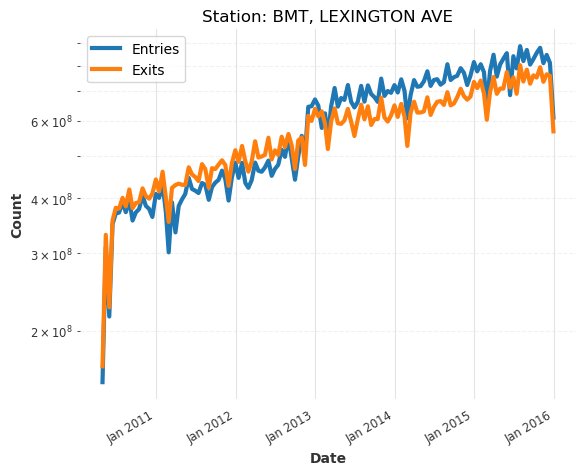

In [47]:
plot_station_count(df, 'SM', 'BMT', 'LEXINGTON AVE')

Almost no offset between entries and exits. In any case we still have the time series behavior of periodical high and lows in the range of the time lenght. Let's see how a prediction model works on this station data.

In [196]:
series = TimeSeries.from_dataframe(group_time, time_col='time', value_cols='entries_inst', freq='SM')
series_train, series_test = series.split_before(0.60)

In [235]:
%%capture

test_mape = []

def eval_RegressionModel(lags):
    model = LinearRegressionModel(lags=lags)
    model.fit(series_train)
    
    series_pred = model.predict(len(series_test))
    test_mape.append(mape(series_test, series_pred))

lags_list = list(range(1, 40, 1))
for period in lags_list:
    eval_RegressionModel(period)

mape_min_index, mape_min = min(enumerate(test_mape), key=itemgetter(1))

best_lags=lags_list[mape_min_index]

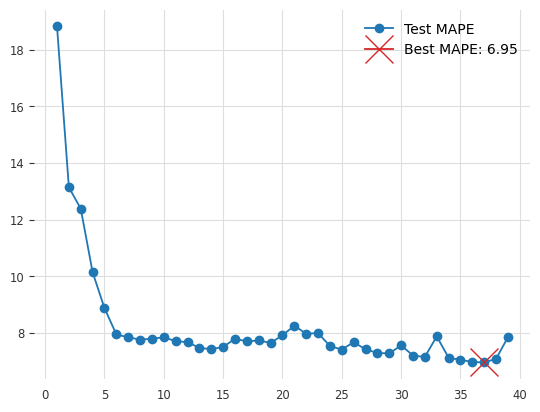

In [201]:
plt.plot(lags_list, test_mape, color='tab:blue', marker='o', label='Test MAPE')
plt.plot(lags_list[mape_min_index], mape_min, marker='x', markersize=20, color='tab:red', label=f'Best MAPE: {mape_min:.2f}' )
plt.legend()
plt.show()

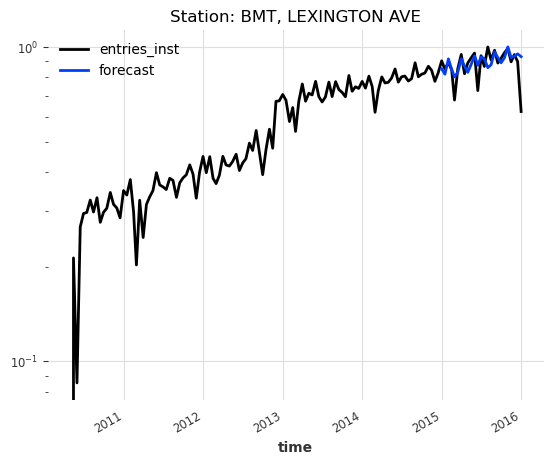

In [202]:
series = TimeSeries.from_dataframe(time_series, time_col='time', value_cols='entries_inst', freq='SM')
series_scaled = Scaler().fit_transform(series)
series_train, series_test = series_scaled.split_before(pd.Timestamp(2015, 1, 1))

model = LinearRegressionModel(lags=lags_list[mape_min_index])
model.fit(series_train)
prediction = model.predict(len(series_test))

series_scaled.plot()
prediction.plot(label="forecast")
plt.title('Station: BMT, LEXINGTON AVE')
plt.yscale('log')
plt.legend()
plt.show()

The mean best absolute percentage error (Mape) was about 6.95%. This value is not ideal, but that was just a quick first view of what we can do with this dataset.

### By Division

First let's create a dictionary with the full divisions names.

In [57]:
division_dict = {
    'IRT': 'Interborough Rapid Transit',
    'BMT': 'Brooklyn-Manhattan Transit',  
    'IND': 'Independent Subway',
    'PTH': 'Port Authority Trans-Hudson (PATH)',
    'RIT': 'Roosevelt Island Tram',
    'SRT': 'Staten Island Rapid Transit' 
}

And write a method that returns the counts by the division.

In [63]:
def generate_group_time_by_division(df, freq, division):
    
    """
    
    Receives a DataFrame with the data sampling frequency and the turnstile filtering parameters.
    
    The cumulative entries and exits are grouped along a timestamp with the defined frequency.
    
    A new DataFrame is build with the parameters columns and the instant value for entries and exits.

    Returns:
        pd.DataFrame: Instant entries and exits DataFrame with new frequency time column.
    """
    
    df = df[
        (df.division == division)
    ]
    
    group = df.groupby(
        [
            pd.Grouper(key='time', freq=freq, closed='right', label ='right')
        ]
    ).agg(
        entries=('entries', 'unique'),
        exits=('exits', 'unique')
    ).reset_index()
    
    df_time_series = pd.DataFrame({}, columns=['time'])
    
    df_time_series.time = group.time
    df_time_series['division'] = division
    df_time_series['entries_inst'] = group['entries'].apply(series_deacumulate).apply(np.sum)
    df_time_series['exits_inst'] = group['exits'].apply(series_deacumulate).apply(np.sum)
    
    return df_time_series

In [66]:
group_division_concat = pd.concat([generate_group_time_by_division(df ,freq='SM', division=division) for division in division_dict.keys()])

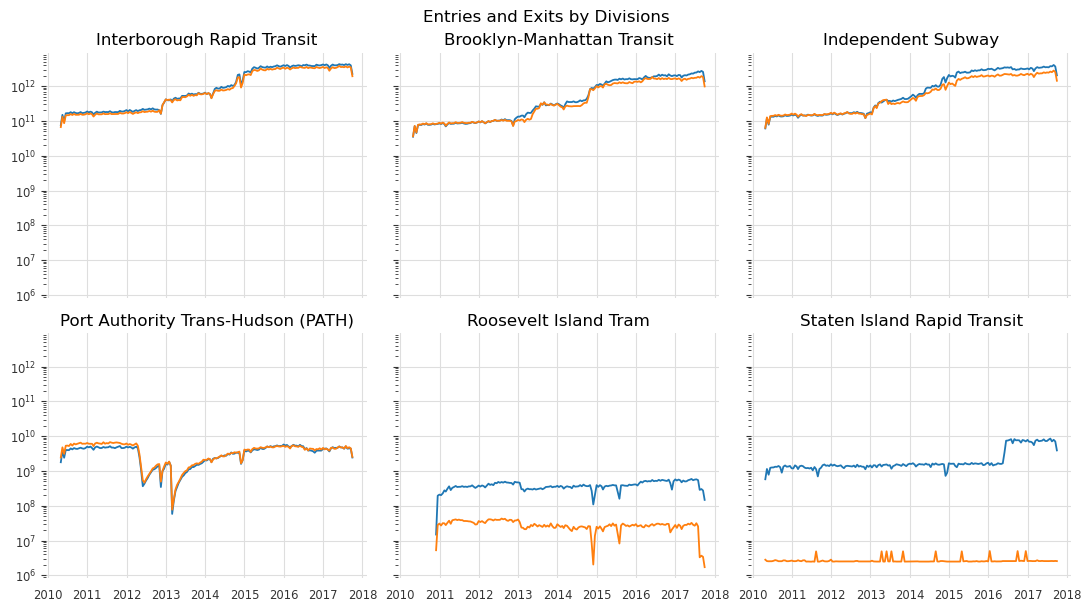

In [206]:
nrows = 2
ncols = 3

fig_divisions, f_divisions_axes = plt.subplots(sharey=True, sharex=True, ncols=ncols, nrows=nrows, constrained_layout=True, figsize=[3.6 * ncols, 3 * nrows])
fig_divisions.suptitle('Entries and Exits by Divisions')

ct = 0
for i in range(nrows):
    for j in range(ncols):
        division = list(division_dict.keys())[ct]
        division_name = division_dict[division]
        f_divisions_axes[i][j].set_title(division_name)
        f_divisions_axes[i][j].plot(group_division_concat[group_division_concat.division == division].time, group_division_concat[group_division_concat.division == division].entries_inst, color='tab:blue', label='Entries')
        f_divisions_axes[i][j].plot(group_division_concat[group_division_concat.division == division].time, group_division_concat[group_division_concat.division == division].exits_inst, color='tab:orange', label='Exits')
        f_divisions_axes[i][j].set_yscale('log')
        ct += 1


The first 3 divisions: Interborough Rapid Transit, Brooklyn-Manhattan Transit and Independent Subway have the highest counts, show more regular series, with entries and exits close and without drops on the count. Let's focus our attention on this divisions.

#### Interborough Rapid Transit

In [287]:
group_irt = group_division_concat[group_division_concat.division == 'IRT']
group_irt.head()

,time,division,entries_inst,exits_inst
0,2010-04-30,IRT,7.573120e+10,6.658678e+10
1,2010-05-15,IRT,1.494690e+11,1.312042e+11
2,2010-05-31,IRT,9.756484e+10,8.601396e+10
3,2010-06-15,IRT,1.650459e+11,1.444408e+11
4,2010-06-30,IRT,1.669766e+11,1.462690e+11


In [58]:
def plot_station_division(df, freq, division):
    group_time = generate_group_time_by_division(df, freq, division)

    fig, ax = plt.subplots()
    ax.plot(group_time.time, group_time.entries_inst, lw=3, color='tab:blue', label='Entries')
    ax.plot(group_time.time, group_time.exits_inst, lw=3, color='tab:orange', label='Exits')

    # Set up grid, legend, and limits
    ax.grid('both')
    ax.grid(which='major', alpha=0.8, linestyle= '-')
    ax.grid(which='minor', alpha=0.4, linestyle= '--')
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    ax.set_title(f'Division: {division_dict[division]}')
    ax.legend(frameon=True)

    formatter1 = EngFormatter(places=1)
    #ax.yaxis.set_major_formatter(formatter1)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')

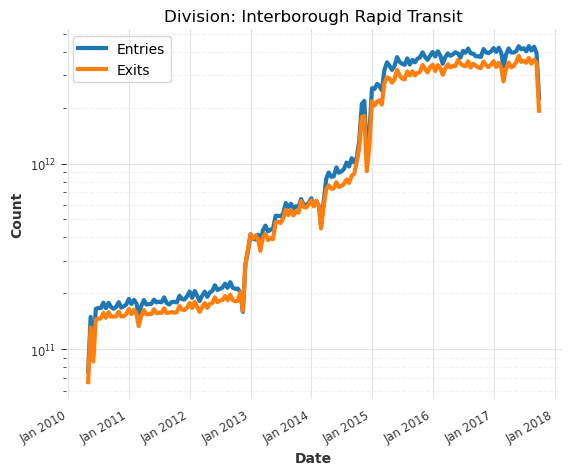

In [59]:
plot_station_division(df, 'SM', 'IRT')

In [289]:
series = TimeSeries.from_dataframe(group_irt, time_col='time', value_cols='entries_inst', freq='SM')
series_train, series_test = series.split_before(0.60)

In [290]:
%%capture

test_mape = []

def eval_RegressionModel(lags):
    model = LinearRegressionModel(lags=lags)
    model.fit(series_train)
    
    series_pred = model.predict(len(series_test))
    test_mape.append(mape(series_test, series_pred))

lags_list = list(range(1, 40, 1))
for period in lags_list:
    eval_RegressionModel(period)

mape_min_index, mape_min = min(enumerate(test_mape), key=itemgetter(1))

best_lags=lags_list[mape_min_index]

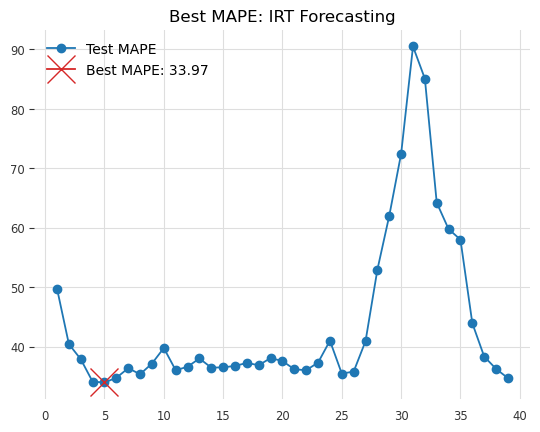

In [291]:
plt.plot(lags_list, test_mape, color='tab:blue', marker='o', label='Test MAPE')
plt.plot(lags_list[mape_min_index], mape_min, marker='x', markersize=20, color='tab:red', label=f'Best MAPE: {mape_min:.2f}' )
plt.title('Best MAPE: IRT Forecasting')
plt.legend()
plt.show()

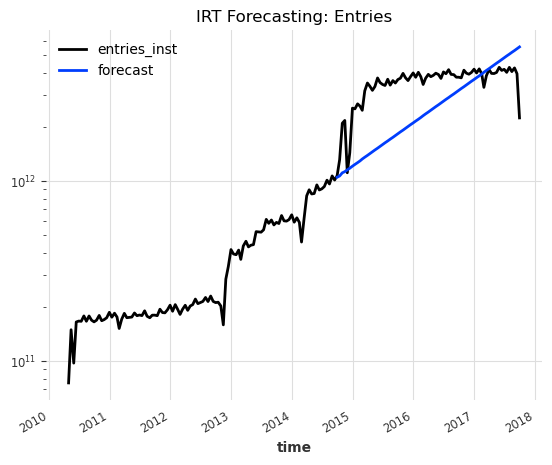

In [292]:
model = LinearRegressionModel(lags=lags_list[mape_min_index])
model.fit(series_train)
prediction = model.predict(len(series_test))

series_irt.plot()
prediction.plot(label="forecast")
plt.title('IRT Forecasting: Entries')
plt.yscale('log')
plt.legend()
plt.show()

The best MAPE of 33.97 provided a terrible forecasting. Let's try to change the train-test split from 0.6 to 0.8 and try again.

In [294]:
series = TimeSeries.from_dataframe(group_irt, time_col='time', value_cols='entries_inst', freq='SM')
series_train, series_test = series.split_before(0.80)

In [295]:
%%capture

test_mape = []

def eval_RegressionModel(lags):
    model = LinearRegressionModel(lags=lags)
    model.fit(series_train)
    
    series_pred = model.predict(len(series_test))
    test_mape.append(mape(series_test, series_pred))

lags_list = list(range(1, 40, 1))
for period in lags_list:
    eval_RegressionModel(period)

mape_min_index, mape_min = min(enumerate(test_mape), key=itemgetter(1))

best_lags=lags_list[mape_min_index]

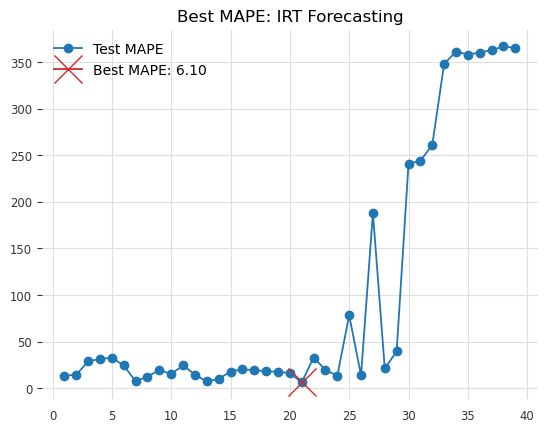

In [296]:
plt.plot(lags_list, test_mape, color='tab:blue', marker='o', label='Test MAPE')
plt.plot(lags_list[mape_min_index], mape_min, marker='x', markersize=20, color='tab:red', label=f'Best MAPE: {mape_min:.2f}' )
plt.title('Best MAPE: IRT Forecasting')
plt.legend()
plt.show()

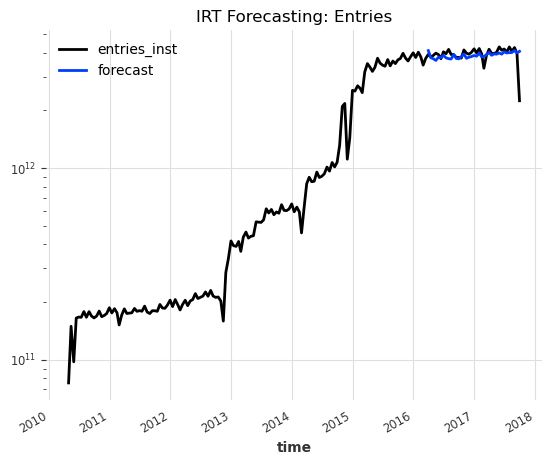

In [297]:
model = LinearRegressionModel(lags=lags_list[mape_min_index])
model.fit(series_train)
prediction = model.predict(len(series_test))

series_irt.plot()
prediction.plot(label="forecast")
plt.title('IRT Forecasting: Entries')
plt.yscale('log')
plt.legend()
plt.show()

Great improvement from changing the split. The MAPE reduced to 6.10 and we have a better forecasting of the last points. That's one problem with this dataset, this huge growth on the counts of an order of magnitude.

This could be due to population growth factors (very unlikely), a large increase in use of the NYC subway system or simply the increase in units taking counts at stations, having more numbers.

What are the busiest stations in this division?

In [96]:
df_irt = df[df.division == 'IRT']
df_irt.head()

,time,division,station,unit,linename,ca,scp,entries,exits
1360,2010-04-17 04:00:00,IRT,RECTOR ST,R304,1,R102,01-03-00,280533.0,17760.0
1361,2010-04-17 04:00:00,IRT,RECTOR ST,R304,1,R102,01-03-01,2525535.0,75083.0
1362,2010-04-17 04:00:00,IRT,RECTOR ST,R304,1,R102,01-05-00,947.0,0.0
1363,2010-04-17 04:00:00,IRT,RECTOR ST,R304,1,R102,01-05-01,0.0,103.0
1364,2010-04-17 04:00:00,IRT,RECTOR ST,R304,1,R102,01-06-00,105008.0,3003789.0


In [92]:
def plot_station_rank(df, division):
    concat_stations = pd.concat([generate_group_time_by_station(df, 'Y', 'BMT', station) for station in df.station.unique()])
    
    group_stations = concat_stations.groupby(['station']).entries_inst.sum().reset_index().sort_values('entries_inst', ascending=False)
    
    g = sns.barplot(x=group_stations[:5].station, y=group_stations[:5].entries_inst)
    plt.xticks(rotation=30, horizontalalignment='right');

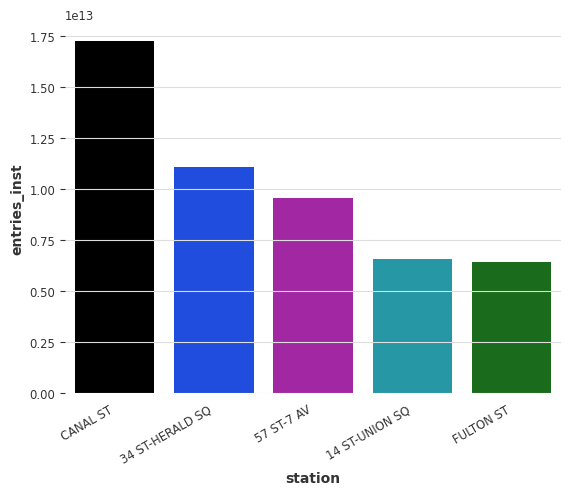

In [126]:
plot_station_rank(df_bmt, 'BMT')

Let's work on the data of the 125 ST.

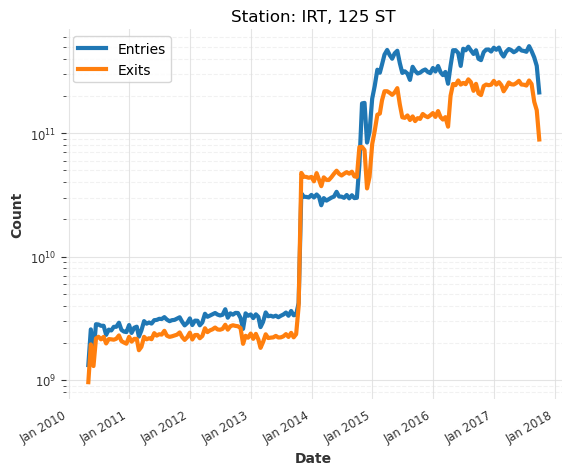

In [60]:
plot_station_count(df, 'SM', 'IRT', '125 ST')

A sharp rise at the end of 2013 shows that this station received new devices for counting passengers, increasing the count of entries and exits. Due to this issue of data acquisition structure, the forecast of the time series is impaired.

### Brooklyn-Manhattan Transit

In [65]:
df_bmt = df[df.division == 'BMT']
df_bmt.head()

,time,division,station,unit,linename,ca,scp,entries,exits
0,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704717.0,928793.0
1,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-01,2697632.0,566683.0
2,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-00,1127722.0,3943492.0
3,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-01,2425570.0,3733289.0
4,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-02,2214633.0,3021589.0


In [69]:
group_bmt = generate_group_time_by_division(df_bmt, 'SM', 'BMT')
group_bmt.head()

,time,division,entries_inst,exits_inst
0,2010-04-30,BMT,3.520857e+10,3.619773e+10
1,2010-05-15,BMT,7.060851e+10,7.198290e+10
2,2010-05-31,BMT,4.482523e+10,4.635728e+10
3,2010-06-15,BMT,7.567871e+10,7.734406e+10
4,2010-06-30,BMT,7.726495e+10,7.925793e+10


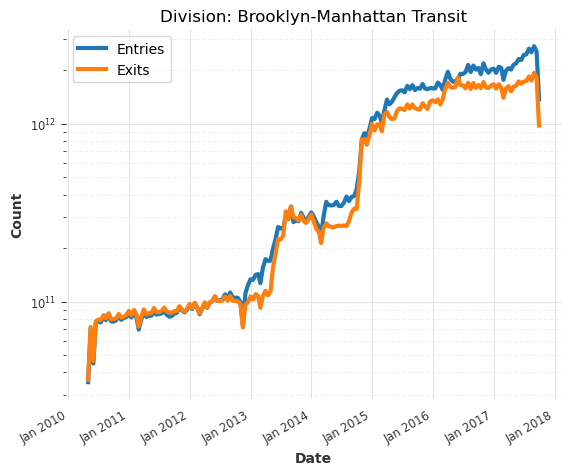

In [70]:
plot_station_division(df, 'SM', 'BMT')

A regular series showing the same behavior of rapid growth in count numbers.

Let's forecast using the 0.8 train/test split.

In [77]:
series = TimeSeries.from_dataframe(group_bmt, time_col='time', value_cols='entries_inst', freq='SM')
series_train, series_test = series.split_before(0.80)

In [78]:
%%capture

test_mape = []

def eval_RegressionModel(lags):
    model = LinearRegressionModel(lags=lags)
    model.fit(series_train)
    
    series_pred = model.predict(len(series_test))
    test_mape.append(mape(series_test, series_pred))

lags_list = list(range(1, 40, 1))
for period in lags_list:
    eval_RegressionModel(period)

mape_min_index, mape_min = min(enumerate(test_mape), key=itemgetter(1))

best_lags=lags_list[mape_min_index]

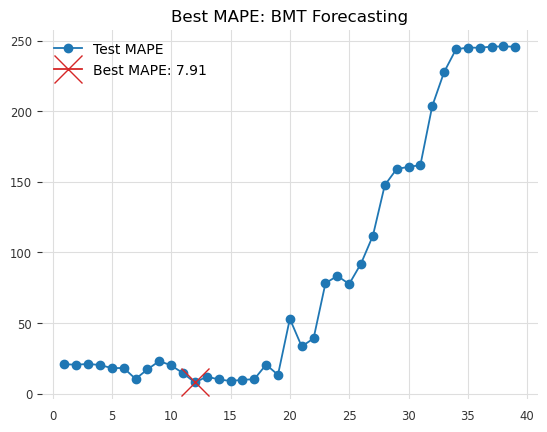

In [79]:
plt.plot(lags_list, test_mape, color='tab:blue', marker='o', label='Test MAPE')
plt.plot(lags_list[mape_min_index], mape_min, marker='x', markersize=20, color='tab:red', label=f'Best MAPE: {mape_min:.2f}' )
plt.title('Best MAPE: BMT Forecasting')
plt.legend()
plt.show()

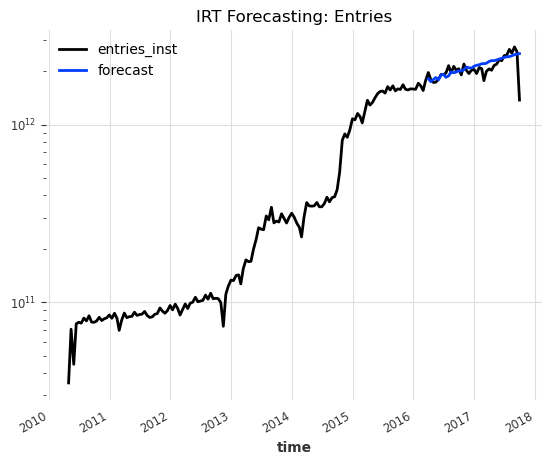

In [80]:
model = LinearRegressionModel(lags=lags_list[mape_min_index])
model.fit(series_train)
prediction = model.predict(len(series_test))

series.plot()
prediction.plot(label="forecast")
plt.title('IRT Forecasting: Entries')
plt.yscale('log')
plt.legend()
plt.show()

The MAPE of 7.91 was the best using Linear Regression forecasting, this number shows a behavior but lacks of real precision. This data need a deeper processing to try increase the prediction.

In [124]:
def plot_station_rank(df, division):
    concat_stations = pd.concat([generate_group_time_by_station(df, 'Y', division, station) for station in df.station.unique()])
    
    group_stations = concat_stations.groupby(['station']).entries_inst.sum().reset_index().sort_values('entries_inst', ascending=False)
    
    g = sns.barplot(x=group_stations[:5].station, y=group_stations[:5].entries_inst)
    plt.xticks(rotation=30, horizontalalignment='right');

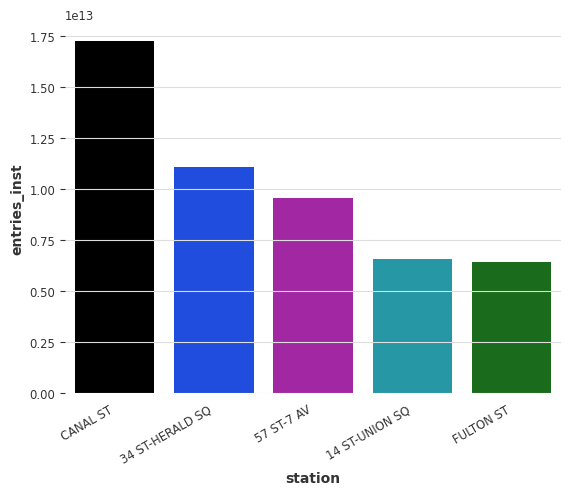

In [90]:
plot_station_rank(df_bmt, 'BMT')

Let's take a look on the CANAL ST station.

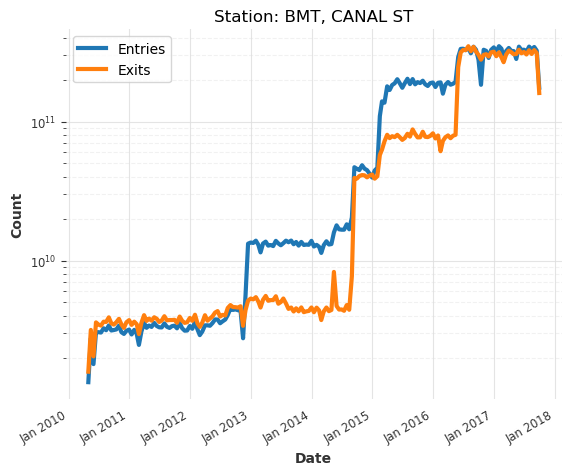

In [91]:
plot_station_count(df, 'SM', 'BMT', 'CANAL ST')

Apparently, at this station, the entry turnstiles received the counting devices before the exit turnstiles, generating this offset between the two curves.

#### Staten Island Rapid Transit

In [109]:
df_srt = df[df.division == 'SRT']
df_srt.head()

,time,division,station,unit,linename,ca,scp,entries,exits
2206,2010-04-17 04:00:00,SRT,ST. GEORGE,R070,1,S101,00-00-00,2145471.0,2674.0
2207,2010-04-17 04:00:00,SRT,ST. GEORGE,R070,1,S101,00-00-01,1804076.0,1404.0
2208,2010-04-17 04:00:00,SRT,ST. GEORGE,R070,1,S101,00-00-02,858679.0,258.0
2209,2010-04-17 04:00:00,SRT,ST. GEORGE,R070,1,S101,00-00-03,1565879.0,2129.0
2210,2010-04-17 04:00:00,SRT,ST. GEORGE,R070,1,S101,00-00-04,1396437.0,2157.0


In [111]:
group_srt = generate_group_time_by_division(df_srt, 'SM', 'SRT')
group_srt.head()

,time,division,entries_inst,exits_inst
0,2010-04-30,SRT,5.760531e+08,2809139.0
1,2010-05-15,SRT,1.137980e+09,2562199.0
2,2010-05-31,SRT,7.781223e+08,2532856.0
3,2010-06-15,SRT,1.229110e+09,2541411.0
4,2010-06-30,SRT,1.255788e+09,2541414.0


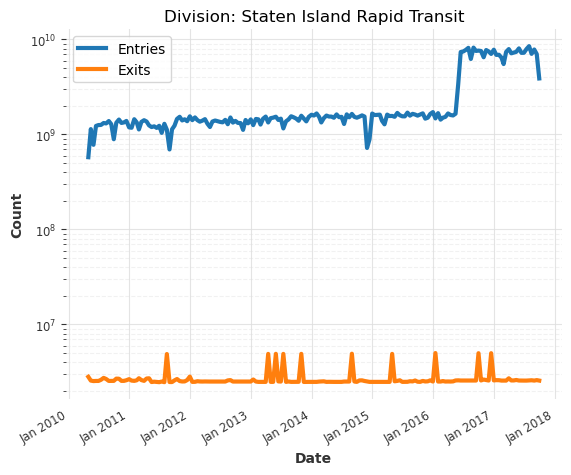

In [112]:
plot_station_division(df, 'SM', 'SRT')

The entries forecasting is more regular from 2010 until 2016, but there is the step that shows the installation of new count devices.

The offset between entries and exits that shows the priority of recording the entries count.

In [119]:
series = TimeSeries.from_dataframe(group_srt[group_srt.time.dt.year < 2016], time_col='time', value_cols='entries_inst', freq='SM')
series_train, series_test = series.split_before(0.80)

In [120]:
%%capture

test_mape = []

def eval_RegressionModel(lags):
    model = LinearRegressionModel(lags=lags)
    model.fit(series_train)
    
    series_pred = model.predict(len(series_test))
    test_mape.append(mape(series_test, series_pred))

lags_list = list(range(1, 40, 1))
for period in lags_list:
    eval_RegressionModel(period)

mape_min_index, mape_min = min(enumerate(test_mape), key=itemgetter(1))

best_lags=lags_list[mape_min_index]

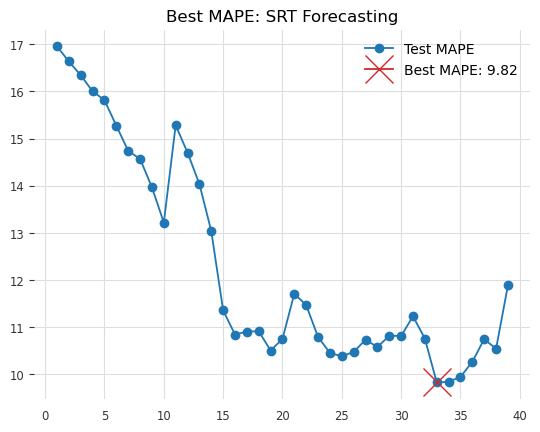

In [121]:
plt.plot(lags_list, test_mape, color='tab:blue', marker='o', label='Test MAPE')
plt.plot(lags_list[mape_min_index], mape_min, marker='x', markersize=20, color='tab:red', label=f'Best MAPE: {mape_min:.2f}' )
plt.title('Best MAPE: SRT Forecasting')
plt.legend()
plt.show()

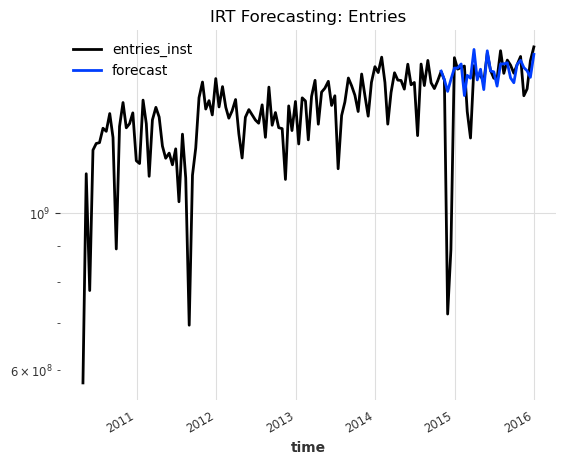

In [122]:
model = LinearRegressionModel(lags=lags_list[mape_min_index])
model.fit(series_train)
prediction = model.predict(len(series_test))

series.plot()
prediction.plot(label="forecast")
plt.title('IRT Forecasting: Entries')
plt.yscale('log')
plt.legend()
plt.show()

Excluding data after 2016, we can have a reasonable forecast with MAPE of 9.82.

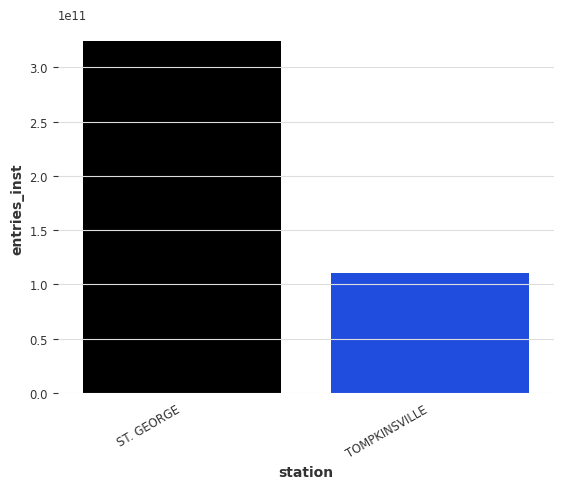

In [125]:
plot_station_rank(df_srt, 'SRT')

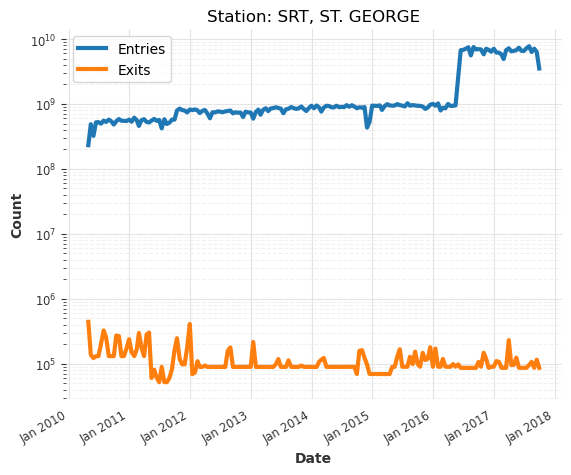

In [127]:
plot_station_count(df, 'SM', 'SRT', 'ST. GEORGE')